## Importing required libraries

In [ ]:
import pandas as pd
import kagglehub
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Flatten, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

## Downloading and Loading The Dataset

In [ ]:
path = kagglehub.dataset_download("dhoogla/unswnb15")

print("Path to dataset files:", path)

100%|██████████| 11.7M/11.7M [00:01<00:00, 7.61MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/dhoogla/unswnb15/versions/5


In [ ]:
train_df = pd.read_parquet(f"{path}/UNSW_NB15_training-set.parquet")
test_df = pd.read_parquet(f"{path}/UNSW_NB15_testing-set.parquet")

print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape)

Training set shape: (175341, 36)
Testing set shape: (82332, 36)


In [ ]:
train_df.head(3)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sload,...,trans_depth,response_body_len,ct_src_dport_ltm,ct_dst_sport_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,is_sm_ips_ports,attack_cat,label
0,0.121478,tcp,-,FIN,6,4,258,172,74.087486,14158.942383,...,0,0,1,1,0,0,0,0,Normal,0
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473373,8395.112305,...,0,0,1,1,0,0,0,0,Normal,0
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,1572.271851,...,0,0,1,1,0,0,0,0,Normal,0


## Checking for duplicate Rows

In [ ]:
num_duplicates1 = train_df.duplicated().sum()
num_duplicates2 = test_df.duplicated().sum()
print(num_duplicates1,num_duplicates2)

78519 32361


## Removing The Duplicates

In [ ]:
train_df = train_df.drop_duplicates()
test_df = test_df.drop_duplicates()

In [ ]:
print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape)

Training set shape: (96822, 36)
Testing set shape: (49971, 36)


## Converting boolean columns to integers

In [ ]:
for col in train_df.select_dtypes(include=["bool"]).columns:
    train_df[col] = train_df[col].astype(int)
    test_df[col] = test_df[col].astype(int)

## Identifying numerical columns (excluding the target column 'label')

In [ ]:
num_cols = train_df.select_dtypes(include=["int8", "int16", "float32"]).columns
print("Numeric columns for scaling:", num_cols)

Numeric columns for scaling: Index(['label', 'ackdat', 'tcprtt', 'dload', 'synack', 'dmean', 'rate',
       'ct_flw_http_mthd', 'ct_dst_sport_ltm', 'smean', 'sload'],
      dtype='object')


# Scaling numerical columns

In [ ]:
scaler = MinMaxScaler()
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])
test_df[num_cols] = scaler.transform(test_df[num_cols])

## Checking class distribution

In [ ]:
print("Class distribution:\n", train_df['label'].value_counts())

Class distribution:
 label
0.0    48894
1.0    47928
Name: count, dtype: int64


## Correlation heatmap

In [ ]:
# Applying One-Hot Encoding to categorical columns
#train_df = pd.get_dummies(train_df, drop_first=True)
#test_df = pd.get_dummies(test_df, drop_first=True)

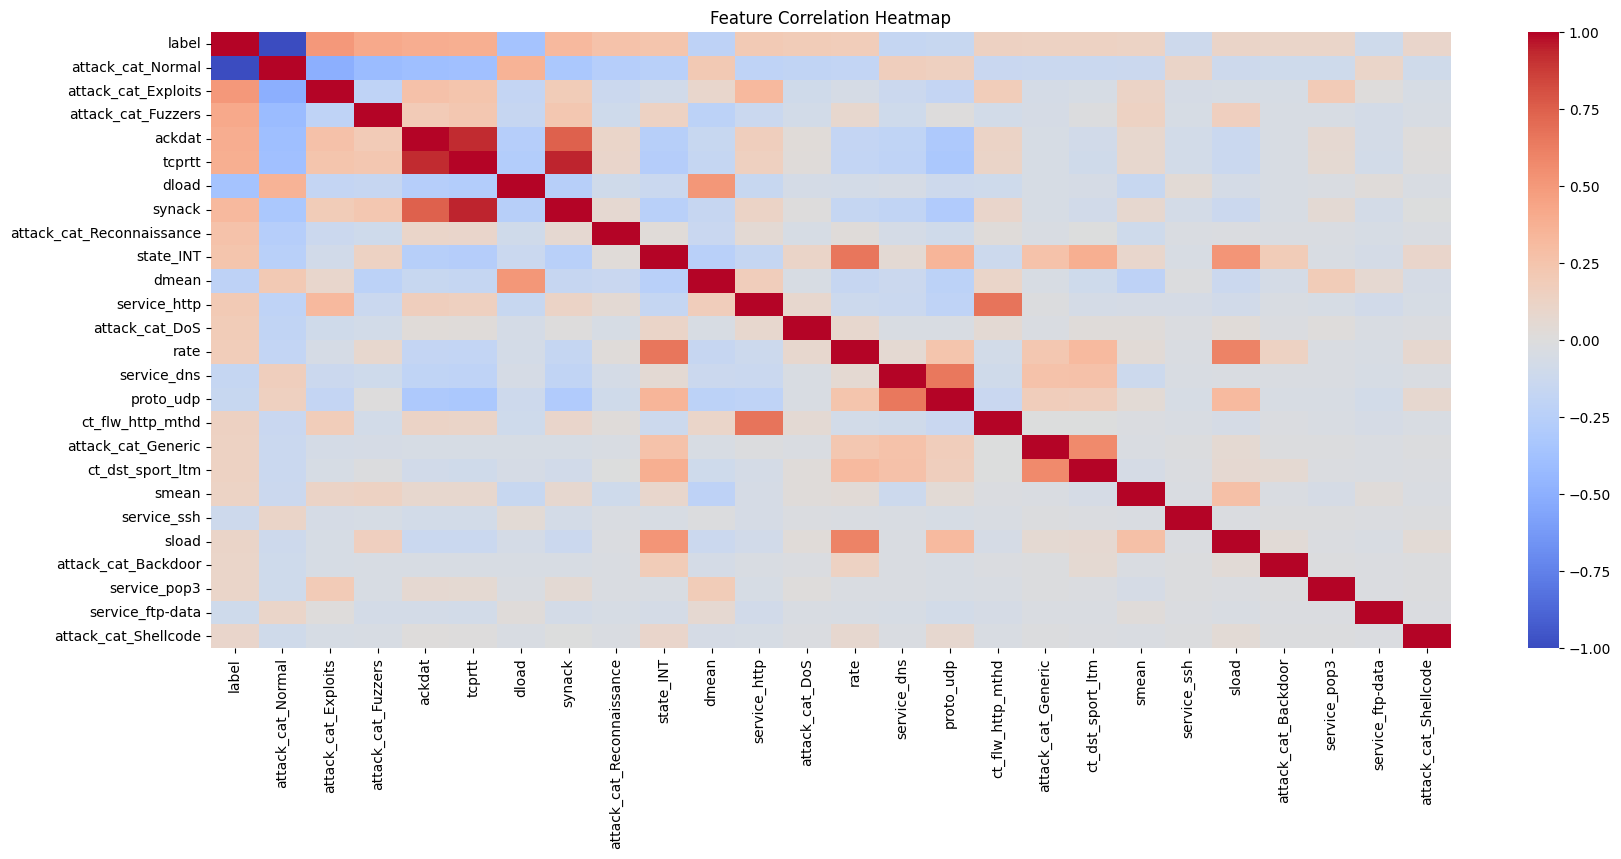

In [ ]:
corr = train_df.corr()
plt.figure(figsize=(20, 8))
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

## Droping features with low correlation to the target

In [ ]:
threshold = 0.1
correlation_with_target = train_df.corr()['label'].abs().sort_values(ascending=False)
features_to_keep = correlation_with_target[correlation_with_target > threshold].index
print("Features retained based on correlation:\n", features_to_keep)

Features retained based on correlation:
 Index(['label', 'attack_cat_Normal', 'attack_cat_Exploits',
       'attack_cat_Fuzzers', 'ackdat', 'tcprtt', 'dload', 'synack',
       'attack_cat_Reconnaissance', 'state_INT', 'dmean', 'service_http',
       'attack_cat_DoS', 'rate', 'service_dns', 'proto_udp',
       'ct_flw_http_mthd', 'attack_cat_Generic', 'ct_dst_sport_ltm', 'smean',
       'service_ssh', 'sload', 'attack_cat_Backdoor', 'service_pop3',
       'service_ftp-data', 'attack_cat_Shellcode'],
      dtype='object')


In [ ]:
train_df = train_df[features_to_keep]
test_df = test_df[features_to_keep]

## Spliting into features and labels

In [ ]:
X_train = train_df.drop(columns=["label"])
y_train = train_df["label"]
X_test = test_df.drop(columns=["label"])
y_test = test_df["label"]

## Converting into Numpy Array

In [ ]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

## Balancing Classes with SMOTE

In [ ]:
print("Before SMOTE:\n", pd.Series(y_train).value_counts())
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print("After SMOTE:\n", pd.Series(y_train).value_counts())

Before SMOTE:
 0.0    48894
1.0    47928
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


After SMOTE:
 0.0    48894
1.0    48894
Name: count, dtype: int64


## Ensuring correct data types

In [ ]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

## Reshaping input data for Transformer model

In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

## Defining Transformer-based Model

In [ ]:
def transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0):
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attention = Dropout(dropout)(attention)
    out1 = LayerNormalization(epsilon=1e-6)(attention + inputs)

    ffn = tf.keras.Sequential([
        Dense(ff_dim, activation="relu"),
        Dense(inputs.shape[-1])
    ])
    ffn_output = ffn(out1)
    ffn_output = Dropout(dropout)(ffn_output)
    return LayerNormalization(epsilon=1e-6)(ffn_output + out1)

def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_blocks, num_classes, dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_blocks):
        x = transformer_block(x, head_size, num_heads, ff_dim, dropout)
    x = Flatten()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    return tf.keras.Model(inputs, outputs)

input_shape = (X_train.shape[1], 1)  # Adjust input shape

## Building The Model

In [ ]:
model = build_transformer_model(input_shape, head_size=64, num_heads=4, ff_dim=128, num_blocks=2, num_classes=2, dropout=0.1)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 25, 1)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 25, 1)          │          1,793 │ input_layer[0][0],     │
│ (MultiHeadAttention)      │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 25, 1)          │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 25, 1)          │              0 │ dropout_1[0][0],       │
│                           │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 25, 1)          │              2 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 25, 1)          │            385 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 25, 1)          │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 25, 1)          │              0 │ dropout_2[0][0],       │
│                           │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 25, 1)          │              2 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 25, 1)          │          1,793 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 25, 1)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 25, 1)          │              0 │ dropout_4[0][0],       │
│                           │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 25, 1)          │              2 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 25, 1)          │            385 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 25, 1)          │              0 │ sequential_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)          

 Total params: 7,950 (31.05 KB)

 Trainable params: 7,950 (31.05 KB)

 Non-trainable params: 0 (0.00 B)

## Training The Model

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=64)

Epoch 1/20
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - accuracy: 0.6149 - loss: 0.6746 - val_accuracy: 0.0481 - val_loss: 0.9191
Epoch 2/20
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6134 - loss: 0.6672 - val_accuracy: 0.0481 - val_loss: 0.9222
Epoch 3/20
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6116 - loss: 0.6681 - val_accuracy: 0.0481 - val_loss: 0.9292
Epoch 4/20
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.6126 - loss: 0.6676 - val_accuracy: 0.0481 - val_loss: 0.9245
Epoch 5/20
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6108 - loss: 0.6684 - val_accuracy: 0.0481 - val_loss: 0.9305
Epoch 6/20
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6167 - loss: 0.6657 - val_accuracy: 0.0481 - val_loss: 0.9310
Epoch 7/20
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6151 - loss: 0.6664 - val_accuracy: 0.0481 - val_loss: 0.9333
Epoch 8/20
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.6112 - loss: 0.668

In [ ]:
results = model.evaluate(X_test, y_test)
print("Test Accuracy:", results[1])

1562/1562 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.4845 - loss: 0.7276
Test Accuracy: 0.6325668692588806
